# CC5215: Privacidad de Datos

## Laboratorio 9

Integrantes: (trabajé solo porque no pude conseguir compañero para el trabajo)

- Nombre: Diego Espinoza

## Preamble

In this lab, we are going to implement the MWEM algorithm seen in class. Furthermore, we will incrementally build the necessary pieces of the algorithm in order to re-use the same logic for a private and a non-private version.

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')

## Question 1 (5 points)

The following code block shows the contingency table for the colums "Age" and "Occupation" in the dataset `adult`.

In [2]:
D = pd.crosstab(
    [adult['Age'], adult['Occupation']],
    np.ones(adult.shape[0]),
    normalize=True).rename(columns={1.0: "Norm_count"})

D

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical         0.000749
    Craft-repair         0.000456
    Exec-managerial      0.000033
    Farming-fishing      0.000293
    Handlers-cleaners    0.001302
...                           ...
90  Other-service        0.000195
    Prof-specialty       0.000163
    Protective-serv      0.000033
    Sales                0.000098
    Transport-moving     0.000033

[843 rows x 1 columns]


Implement the `generate_n_qweights` function that creates a list of size `n` of binary weights (values being either 0 or 1) for a dataframe `D`:

_Hints_: Use the function `np.random.choice` to create a matrix with the dimentsions of `D` and use it to create a pd.Dataframe. Also, the properties `.shape`, `.index`, `.columns` of Dataframe may be useful.

In [6]:
def generate_n_qweights(D, n):
    """
    Generate a list of n dataframes, of the same structure as D, where each dataframe cell is either 0 or 1.

    Parameters:
        D (pd.Dataframe): The data for which the weight vectors will be generated
        n (int): The number of vectors to generate

    Returns:
        list(pd.Dataframe): A list of dataframes with the same shape of D, where each value is either 0 or 1

    Example:
        D = pd.Dataframe([0.1, 0.5, 0.4])
        qs = generate_n_qweights(D, 10)
        print(qs[0]) # Output: Dataframe([1, 0, 1])
    """
    #Recordemos que queremos tener una función que cree una 
    #cantidad de n dataframes diferentes con el mismo tamaño
    #que el dataframe original, pero con 1's y 0's en cada
    #una de las celdas de ellos. 
    qweights = []
    for _ in range(n):
        #ahora usamos el hint que nos dieron en el enunciado
        q = np.random.choice([0,1], size=D.shape)
        #ahora convertimos a dataframe
        q_df = pd.DataFrame(q, 
                            index=D.index,
                            columns=D.columns)
        #por último usamos append porque qweights es una 
        #lista de python.
        qweights.append(q_df)
    
    return qweights
    
qs = generate_n_qweights(D, 40)

qs[0]

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical                0
    Craft-repair                0
    Exec-managerial             0
    Farming-fishing             0
    Handlers-cleaners           0
...                           ...
90  Other-service               0
    Prof-specialty              0
    Protective-serv             0
    Sales                       0
    Transport-moving            0

[843 rows x 1 columns]

In [7]:
# TESTS

q_test = generate_n_qweights(D, 1)[0]

# This tests should NEVER fail
assert len(q_test) == len(D)
assert all([abs(w) <= 1 for w in q_test.values.flatten()])

## Question 2 (5 points)

From a `q` matrix, we can create a query `Q` that receives a dataframe `D` and calculates the weighted sum of `D` and `q`. Implement `generate_query_from_qweigth` that receives a `q` matrix and returns a tuple containing the same `q` and a function `Q`.

In [30]:
def generate_query_from_qweigth(q):
    """
    Generate a query function from a given query weight.

    Parameters:
        q (pd.Dataframe): The query weight vector.

    Returns:
        tuple: A tuple containing the query weight vector and the query function.
    """
    #calculamos Q como la suma ponderada de D y Q.
    def Q(D):
        return (q * D).to_numpy().sum()
    #devolvemos la tupla que contiene el vector q y Q
    return (q, Q)

Qs = [generate_query_from_qweigth(q) for q in qs]

print("Query:", Qs[0][1])
print("=" * 50)
print("Query data:")
Qs[0][0]

Query: <function generate_query_from_qweigth.<locals>.Q at 0x16d9be8b0>
Query data:


col_0                  Norm_count
Age Occupation                   
17  Adm-clerical                0
    Craft-repair                0
    Exec-managerial             0
    Farming-fishing             0
    Handlers-cleaners           0
...                           ...
90  Other-service               0
    Prof-specialty              0
    Protective-serv             0
    Sales                       0
    Transport-moving            0

[843 rows x 1 columns]

## Question 3 (2 points)

For starting writing the MWEM implementation, the first step is to generate a first guess. Implement `gen_first_guess` that creates a dataframe similar to its argument `D`, but where each cell simply contains $\frac{1}{n}$, where $n$ is the size (number of cells) of `D`.

In [31]:
def gen_first_guess(D):
    #primero obtenemos el numero de celdas, que es la
    #multiplicación de filas por columnas de la matriz D 
    #que es la original
    n = D.size
    #ahora calculamos el valor con el que rellenaremos
    #cada una de las celdas.
    valor_homogeneo = 1.0 / n
    #por último creamos una matriz que contiene dichos
    #valores y la dejamos en formato dataframe de pandas
    q = np.full(D.shape, valor_homogeneo)
    q_df = pd.DataFrame(q, 
                        index=D.index,
                        columns=D.columns)
    return q_df
    

In [32]:
# TESTS

D0_test = gen_first_guess(D)

assert D0_test.shape == D.shape
assert np.isclose(D0_test.values.sum(), 1.0)

D0_test

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical         0.001186
    Craft-repair         0.001186
    Exec-managerial      0.001186
    Farming-fishing      0.001186
    Handlers-cleaners    0.001186
...                           ...
90  Other-service        0.001186
    Prof-specialty       0.001186
    Protective-serv      0.001186
    Sales                0.001186
    Transport-moving     0.001186

[843 rows x 1 columns]

## Question 4 (6 points)

Our implementation of MWEM is going to be parametrized by the way we calculate the argmax error query, and the way we calculate the erorr/correction. Implement `get_i_max_nonDP`, that returns the index of the query that maximizes the error between `D` and `D_prev`. Additionally, implement `calc_correction_nonDP` that returns the `error` variable seen in class.

In [33]:
def get_i_max_nonDP(D, D_prev, queries):
    """
    Determine the index of the maximum query based on the absolute difference of query results.

    Parameters:
        D (pandas.DataFrame): The input data.
        D_prev (pandas.DataFrame): The previous distribution.
        queries (list(tuple)): List of pairs (a dataframe and a function) representing each query

    Returns:
        int: The index of the maximum query.
    """
    errors = []
    for i, (q_matrix, Q) in enumerate(queries):
        Q_D = Q(D)
        Q_D_prev = Q(D_prev)
        error = abs(Q_D - Q_D_prev)
        errors.append(error)
    i_max = np.argmax(errors)
    return i_max

def calc_correction_nonDP(Q, D, D_prev):
    """
    Calculate the correction factor for a query without using differential privacy.

    Parameters:
        Q (function): The query function.
        D (pandas.DataFrame): The input data.
        D_prev (pandas.DataFrame): The previous distribution.

    Returns:
        float: The correction (or error) factor for the query.
    """
    real = Q(D)
    estimated = Q(D_prev)
    return real - estimated

In [35]:
# TESTS

D_prev_test = gen_first_guess(D)

assert get_i_max_nonDP(D, D_prev_test, Qs) < len(Qs)
assert abs(calc_correction_nonDP(Qs[0][1], D, D_prev_test)) < 1

## Question 5 (14 points)

We finally have all the parts necessary to build the MWEM algorithm. Implement MWEM as seen in class, with one subtlety: besides `D`, `queries` and `iterations`, the function must receive two functions that calculate the argmax error and the correction, respectively.

_Hint:_ As we are working with arithmetic over numbers between 0 and 1, it is probable that you may encounter floating approximation errors. It is recommended that you normalize the datasets you generate in each iteration to make sure that the elements sum up to exactly 1.

In [67]:
def MWEM_base(D, queries, iterations, get_i_max, calc_correction):
    """
    Perform the Multiplicative Weights Exponential Mechanism (MWEM) algorithm.

    Parameters:
        D (pandas.DataFrame): The input data.
        queries (list): List of queries to be performed
                        in each iteration.
                        Each query is a tuple containing its 
                        query data (dataframe, i.e. `q`s) 
                        and the query function (i.e. `Q`s).
        iterations (int): Number of iterations to perform.
        get_i_max (function): Function to determine the 
                              index of the maximum query.
            Signature: get_i_max(D, D_prev, queries) -> int
        calc_correction (function): Function to calculate the correction factor for a query.
            Signature: calc_correction(Query_max, D, D_prev) -> float

    Returns:
        pandas.DataFrame: The final result after performing the MWEM iterations.
    """
    #generamos primero que todo una primera suposición o distribución
    #uniforme sobre U
    D_i = gen_first_guess(D)
    #para cada una de las iteraciones
    for _ in range(iterations):
        #buscamos el índice de la query con mayor error 
        #usando la función get_i_max 
        i_max = get_i_max(D, D_i, queries)
        #obtenemos las queries
        q, Q = queries[i_max]
        
        #ahora calculamos la corrección, es decir, 
        #el error inducido por la consulta anterior
        error = calc_correction(Q, D, D_i)
        
        #por último, actualizo el dato sintético
        # (Multiplicative Weights)
        updated = D_i * np.exp(q * error/2)
        
        #normalizamos el nuevo dato sintético
        D_i = updated / (updated.values.sum())
        
    return D_i

We can now instantiate `MWEM_base` in the definition of `MWEM_nonDP` using the previously defined functions:

In [68]:
def MWEM_nonDP(D, queries, iterations):
    return MWEM_base(D, queries, iterations, get_i_max_nonDP, calc_correction_nonDP)

MWEM_result = MWEM_nonDP(D, Qs, 20)

MWEM_result

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical         0.001192
    Craft-repair         0.001281
    Exec-managerial      0.001156
    Farming-fishing      0.001036
    Handlers-cleaners    0.001222
...                           ...
90  Other-service        0.001145
    Prof-specialty       0.001193
    Protective-serv      0.001282
    Sales                0.001148
    Transport-moving     0.001105

[843 rows x 1 columns]

In [69]:
# TEST

assert MWEM_result.shape == D.shape
assert np.isclose(MWEM_result.values.sum(), 1.0)

## Question 6 (8 points)

The following code-block shows the implementation of the exponential mechanism. Use `exponential` and `laplace_mech` to implement `get_i_max_DP` and `calc_correction_DP`, the differentially-private counterparts of the functions implemented in Question 4. Since these functions must receive the sensitivity and the epsilon and return the expected function by `MWEM_base`, e.g. `get_i_max_DP` is a function that takes `sensitivity` and `epsilon` and returns a new function that receives `D`, `D_prev` and `queries`.

In [70]:
def exponential(x, R, u, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]

    # Calculate the probability for each element, based on its score
    factors = [epsilon * score / (2 * sensitivity) for score in scores]
    probabilities = [np.exp(factor) for factor in factors]

    # Normalize the probabilties so they sum up to 1
    p_sum = sum(probabilities)
    probabilities = [float(p_i) / p_sum for p_i in probabilities]

    # Choose an element from R based on the probabilities
    return np.random.choice(R, 1, p=probabilities)[0]

In [71]:
def get_i_max_DP(sensitivity, epsilon):
    """Esta función devuelve otra función

    Input:
        sensitivity (float): sensibilidad de las consultas
        epsilon (float): bucket de privacidad
        
    Output: 
        inner: función que toma los datos reales D, 
        el dataset estimado D_prev y las consultas "queries"
        Usa el mecanismo exponencial definido antes para
        elegir el índice de la consulta que tiene el 
        mayor error (entre Q(D) y Q(D_prev)) pero de forma
        diferencialmente privada (DP).
    """
    def inner(D, D_prev, queries):

        def u(x, i):
            """ahora definimos la función de utilidad necesaria
            para el mecanismo exponencial

            Args:
                x: es una tupla que contiene (D, D_prev)
                   que se pasan como input común.
                i: es un índice de consulta 

            Returns:
                Q es la consult: 
            """
            D, D_prev = x
            #definimos Q como la consulta número i
            Q = queries[i][1]
            #ahora la resta o diferencia de los valores verdaderos
            #y estimados, ponemos el signo menos porque
            #el mecanismo exponencial selecciona según máxima
            #utilidad, y aquí queremos elegir el índice que 
            #tenga el mayor error absoluto.
            return -abs(Q(D) - Q(D_prev))

        #ahora definimos el conjunto de posibles elecciones que 
        #el mecanismo exponencial puede hacer (algo como
        # R = [0,1,...,N-1], donde N es el número de consultas)
        R = list(range(len(queries)))
        x = (D, D_prev)
        return exponential(x, R, u, sensitivity, epsilon)
    
    return inner

In [78]:
def calc_correction_DP(sensitivity, epsilon):
    """Dada una sensibilidad y un presupuesto
    de privacidad, devuelve otra función que hace lo mismo 
    que la definida en la pregunta 4 pero Diferencialmente
    Privada, porque aplica el mecanismo de Laplace. 

    Input:
        sensitivity (float): sensibilidad de la consulta
        epsilon (float): presupuesto o bucket de privacidad
        
    Ouput: 
        inner: función que devuelve el error pero esta vez
        con un ruido de Laplace aplicado
    """
    def inner(Q, D, D_prev):
        #primero calculamos la respuesta real
        real = Q(D)
        #luego calculamos la respuesta estimada
        estimado = Q(D_prev)
        #en tercer lugar calculamos el ruido
        error = real - estimado
        return laplace_mech(error, sensitivity, epsilon)
    
    return inner

In [79]:
# Test

epsilon_test = 1.0

assert get_i_max_DP(1, epsilon_test)(D, D_prev_test, Qs) < len(Qs)

## Question 7 (6 points)

We can finally define `MWEM_DP` by instantiating `MWEM_base` with our differentially private definitions:

In [80]:
def MWEM_DP(D, queries, iterations, epsilon):
    return MWEM_base(D, queries, iterations, get_i_max_DP(1, epsilon / (2 * iterations)), calc_correction_DP(1, epsilon / (2 * iterations)))

# Just testing that it runs; no meaningful choice of #iterations or epsilon here.
DP_MWEM_result = MWEM_DP(D, Qs, 20, 80.0)

DP_MWEM_result

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical         0.000589
    Craft-repair         0.001392
    Exec-managerial      0.000894
    Farming-fishing      0.000167
    Handlers-cleaners    0.000278
...                           ...
90  Other-service        0.000910
    Prof-specialty       0.002072
    Protective-serv      0.000455
    Sales                0.001026
    Transport-moving     0.000251

[843 rows x 1 columns]

If you have succesfully implemented MWEM (private and non-private) the following code should plot the responses for 40 new random queries, applied to the original dataframe, and the generated dataframes:

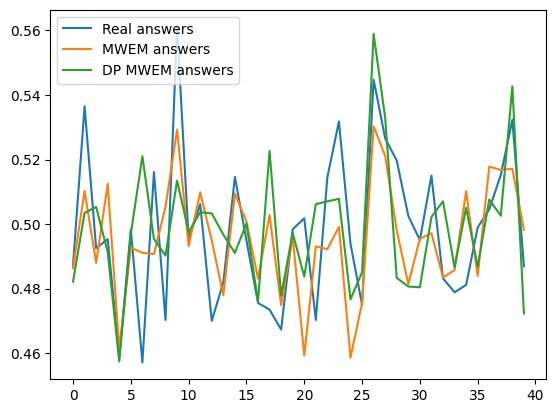

In [81]:
# Test how MWEM and DP-MWEM generalize

qs_test = generate_n_qweights(D, 40)
Qs_test = [generate_query_from_qweigth(q) for q in qs_test]

indexes = range(0, len(qs_test))
real_answers = [Q_i(D) for (_, Q_i) in Qs_test]
mwem_answers = [Q_i(MWEM_result) for (_, Q_i) in Qs_test]
dp_mwem_answers = [Q_i(DP_MWEM_result) for (_, Q_i) in Qs_test]

plt.plot(indexes, real_answers, label="Real answers")
plt.plot(indexes, mwem_answers, label="MWEM answers")
plt.plot(indexes, dp_mwem_answers, label="DP MWEM answers")

plt.legend()
plt.show()

- In a few sentences, and based on the previous plot, how would you describe the accuracy of the MWEM mechanism (both the private and non-private versions)?
- Why do you think it is sensible to generate 40 new queries instead of using the queries we already had?
- Notice that when we instantiated `get_i_max_DP` and `calc_correction_DP`, we specified a sensitivity of $1$ for our queries. Justify this decision.

## Question 8 (10 points)

The following code generates a plot that shows how the number of iterations in MWEM (non-private) affects the similarity between the original dataframe and the generated one:

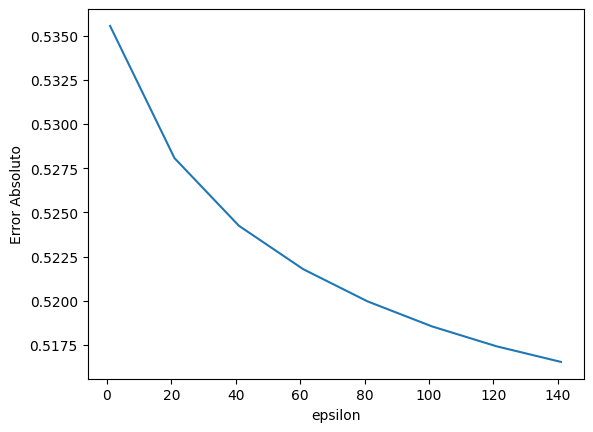

In [82]:
# KL divergence is a measure that can be used to measure the distance between
# two probability distributions
def KLdiv(P, Q):
    return (P * np.log(P / Q)).values.sum()

iterations = range(1, 150, 20)

errors_per_iteration = [KLdiv(D, MWEM_nonDP(D, Qs, iteration)) for iteration in iterations]

plt.xlabel("epsilon")
plt.ylabel("Error Absoluto")
plt.plot(iterations, errors_per_iteration)

- Describe the results showed in the figure
- In a few sentences, provide an intuition for such behavior

The following shows the same information as above but now for the DP version of MWEM:


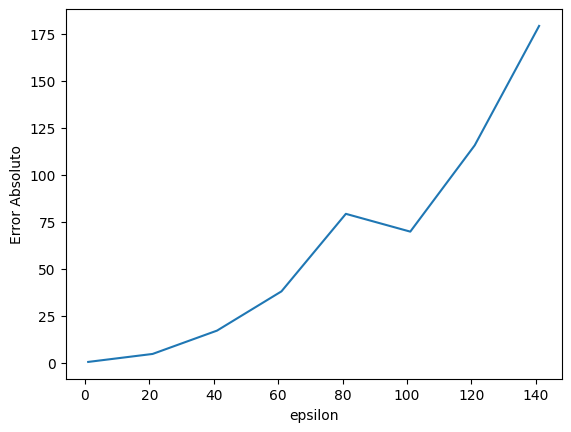

In [83]:
epsilon = 20.0

iterations = range(1, 150, 20)

errors_per_iteration_DP = [KLdiv(D, MWEM_DP(D, Qs, iteration, epsilon)) for iteration in iterations]

plt.xlabel("epsilon")
plt.ylabel("Error Absoluto")
plt.plot(iterations, errors_per_iteration_DP)

- Compare the two figures. What does it change?
El error absoluto crece en el caso DP

- Why do you think we did not obtain the same behavior as before?
Porque uno es diferencialmente privado y el otro no, y porque el error en ambos casos vienen dados por el error de laplace y otros y en el otro no.

- (Without modifying the code) what should you change in order to "recover" the behavior of the previous figure?
Tendría que cambiar la sensibilidad de la consulta, o bien el bucket de privacidad o bien alguna otra variable como las consultas en sí.

## Question 9 (4 points)

Finally, write the necessary code (similar to the code blocks above 🙄) to plot how the DP MWEM reacts to different privacy budgets for a fixed number of iterations (20):

In [ ]:
epsilons =  [0.5, 0.8, 1, 2, 4, 8, 16, 32, 64]

iterations = 20


## complete here

- Based on the figure, what do you think is a "good" privacy budget **per iteration** for our dataframe? Explain your reasoning.
- Is your "good" budget-per-iteration similar to the one used in Q7? Is it smaller or bigger? Justify or argue against the budget used in Q7.